In [ ]:
!pip install pdfplumber beautifulsoup4 matplotlib seaborn requests pandas


In [ ]:
import os
import requests
from bs4 import BeautifulSoup
import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directory to store downloaded financial PDFs
DOWNLOAD_DIR = "financial_statements"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)


In [ ]:
def scrape_and_download_pdfs(url):
    print("Scraping and downloading financial PDFs...")
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all PDF links
    pdf_links = []
    for link in soup.find_all("a", href=True):
        if link["href"].endswith(".pdf"):
            pdf_links.append(requests.compat.urljoin(url, link["href"]))

    # Download PDFs
    pdf_files = []
    for pdf_link in pdf_links:
        filename = os.path.join(DOWNLOAD_DIR, os.path.basename(pdf_link))
        with open(filename, "wb") as f:
            f.write(requests.get(pdf_link).content)
        pdf_files.append(filename)
    print(f"Downloaded {len(pdf_files)} PDFs.")
    return pdf_files


In [ ]:
def extract_text_from_pdfs(pdf_files):
    print("Extracting data from PDFs...")
    extracted_text = []
    for pdf_file in pdf_files:
        with pdfplumber.open(pdf_file) as pdf:
            for page in pdf.pages:
                extracted_text.append(page.extract_text())
    return extracted_text


In [ ]:
def parse_financial_data(raw_data):
    print("Parsing financial metrics...")
    financial_data = {"Year": [], "Revenue": [], "Net Income": [], "Cash Flow": []}

    for text in raw_data:
        lines = text.split("\n")
        for line in lines:
            if "Revenue" in line or "Total Revenue" in line:
                try:
                    revenue = int(line.split()[-1].replace(",", "").replace("$", ""))
                    financial_data["Revenue"].append(revenue)
                except:
                    continue
            elif "Net Income" in line or "Net Earnings" in line:
                try:
                    net_income = int(line.split()[-1].replace(",", "").replace("$", ""))
                    financial_data["Net Income"].append(net_income)
                except:
                    continue
            elif "Cash Flow" in line or "Net Cash Flow" in line:
                try:
                    cash_flow = int(line.split()[-1].replace(",", "").replace("$", ""))
                    financial_data["Cash Flow"].append(cash_flow)
                except:
                    continue
            elif "20" in line:  # Detect year
                try:
                    year = int(line.split()[0])
                    if 2000 <= year <= 2025:
                        financial_data["Year"].append(year)
                except:
                    continue

    # Align columns by length
    min_len = min(len(financial_data["Year"]), len(financial_data["Revenue"]),
                  len(financial_data["Net Income"]), len(financial_data["Cash Flow"]))
    for key in financial_data:
        financial_data[key] = financial_data[key][:min_len]

    if not financial_data["Year"]:
        print("No financial data extracted. Exiting.")
        return None
    return pd.DataFrame(financial_data)


In [ ]:
def visualize_financial_data(df):
    print("Visualizing financial trends...")
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # Plot trends
    for column in ["Revenue", "Net Income", "Cash Flow"]:
        sns.lineplot(x="Year", y=column, data=df, marker="o", label=column)

    plt.title("Financial Trends Over the Years")
    plt.xlabel("Year")
    plt.ylabel("Amount (in millions)")
    plt.legend()
    plt.show()


Scraping and downloading financial PDFs...
Downloaded 237 PDFs.
Extracting data from PDFs...
Parsing financial metrics...
Financial data saved to 'financial_data.csv'.
Visualizing financial trends...


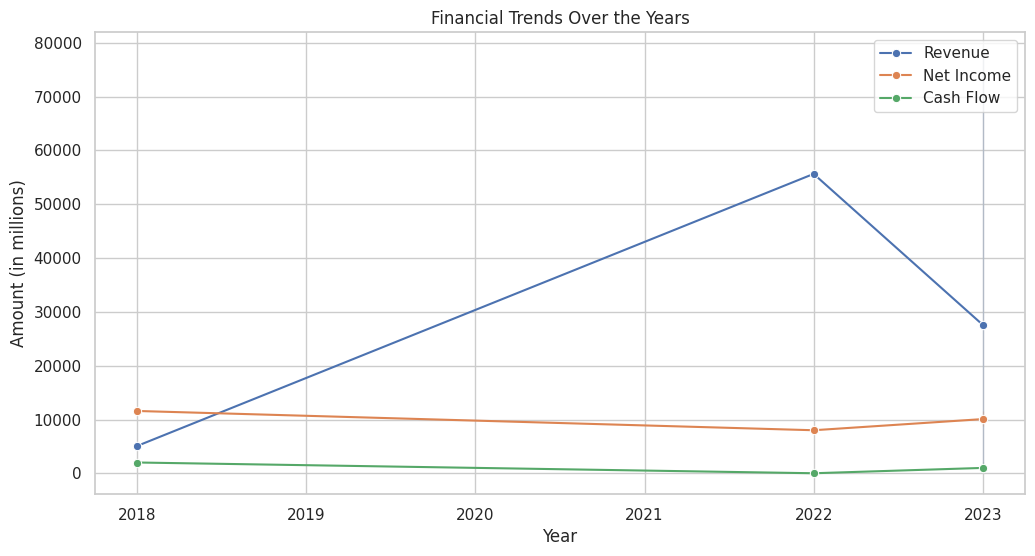

In [ ]:
def main():
    # URL of Walt Disney's Investor Relations page (example URL; replace if necessary)
    base_url = "https://thewaltdisneycompany.com/investor-relations/"

    # Step 1: Scrape and Download PDFs
    pdf_files = scrape_and_download_pdfs(base_url)

    # Step 2: Extract Text from PDFs
    raw_data = extract_text_from_pdfs(pdf_files)

    # Step 3: Parse Financial Data
    financial_df = parse_financial_data(raw_data)
    if financial_df is None:
        return

    # Save the DataFrame as CSV
    financial_df.to_csv("financial_data.csv", index=False)
    print("Financial data saved to 'financial_data.csv'.")

    # Step 4: Visualize Financial Data
    visualize_financial_data(financial_df)

if __name__ == "__main__":
    main()


In [ ]:
from google.colab import files
files.download('financial_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>